DSCI 552
Tara Erberich 
Student ID: 9237580532
Github: taerber 

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score  
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## 1.(a) --> Load Data

In [190]:
# read in data
train = pd.read_csv("data/aps_failure_training_set.csv", skiprows = 20);
test = pd.read_csv("data/aps_failure_test_set.csv", skiprows = 20);

data = pd.concat([train,test])

# Replace ? with NaN for imputer to work
data = data.replace('na', 'NaN')
train = train.replace('na', 'NaN')
test = test.replace('na', 'NaN')
#display(ccData)

# encode Y so pos = 1 & neg = 0
data['class']= data['class'].map({'pos': 1, 'neg': 0})
train['class']= train['class'].map({'pos': 1, 'neg': 0})
test['class']= test['class'].map({'pos': 1, 'neg': 0})


# split into train and test
dataX = data.iloc[:, 1:]
dataY = data.iloc[:, 0:1]
trainX = train.iloc[:, 1:]
trainY = train.iloc[:, 0:1]
testX = test.iloc[:, 1:]
testY = test.iloc[:, 0:1]




## 1.(b).i 

There are a handful of ways to replace missing data, a common technique is using the mean, median, or mode of the sample to replace missing values. One can also simply remove the rows/columns that have missing values but has more disatvantages and there are better methods. Hot deck imputation finds a random sample with similar values and replaces the missing value with the similar value. Cold deck imputation is similar to hot deck but the sample is picked systematically. Regregression imputation allows one to predict the missing value by using regression to regress on the missing value vs all other values.There are many more methods but these are a few of the common options I read about.

Here I have picked to use a mean imputation technique.

In [191]:
m = SimpleImputer(missing_values = np.NAN, strategy = 'mean')

# all data
m.fit(dataX)
dataX = m.transform(dataX)
dataX = pd.DataFrame(dataX)

# train
m.fit(trainX)
trainX = m.transform(trainX)
trainX = pd.DataFrame(trainX)


# test
m.fit(testX)
testX = m.transform(testX)
testX = pd.DataFrame(testX)


display(trainX)
display(trainY)

0         1             2              3    4     5    6    7    \
0       76698.0  0.713189  2.130706e+09     280.000000  0.0   0.0  0.0  0.0   
1       33058.0  0.713189  0.000000e+00  190620.639314  0.0   0.0  0.0  0.0   
2       41040.0  0.713189  2.280000e+02     100.000000  0.0   0.0  0.0  0.0   
3          12.0  0.000000  7.000000e+01      66.000000  0.0  10.0  0.0  0.0   
4       60874.0  0.713189  1.368000e+03     458.000000  0.0   0.0  0.0  0.0   
...         ...       ...           ...            ...  ...   ...  ...  ...   
59995  153002.0  0.713189  6.640000e+02     186.000000  0.0   0.0  0.0  0.0   
59996    2286.0  0.713189  2.130707e+09     224.000000  0.0   0.0  0.0  0.0   
59997     112.0  0.000000  2.130706e+09      18.000000  0.0   0.0  0.0  0.0   
59998   80292.0  0.713189  2.130706e+09     494.000000  0.0   0.0  0.0  0.0   
59999   40222.0  0.713189  6.980000e+02     628.000000  0.0   0.0  0.0  0.0   

       8       9    ...        160       161        162        163        164  \
0      0.0     0.0  ...  1240520.0  493384.0   721044.0   469792.0   339156.0   
1      0.0     0.0  ...   421400.0  178064.0   293306.0   245416.0   133654.0   
2      0.0     0.0  ...   277378.0  159812.0   423992.0   409564.0   320746.0   
3      0.0   318.0  ...      240.0      46.0       58.0       44.0       10.0   
4      0.0     0.0  ...   622012.0  229790.0   405298.0   347188.0   286954.0   
...    ...     ...  ...        ...       ...        ...        ...        ...   
59995  0.0  2564.0  ...   998500.0  566884.0  1290398.0  1218244.0  1019768.0   
59996  0.0     0.0  ...    10578.0    6760.0    21126.0    68424.0      136.0   
59997  0.0     0.0  ...      792.0     386.0      452.0      144.0      146.0   
59998  0.0     0.0  ...   699352.0  222654.0   347378.0   225724.0   194440.0   
59999  0.0     0.0  ...   440066.0  183200.0   344546.0   254068.0   225148.0   

            165       166       167  168   169  
0      157956.0   73224.0       0.0  0.0   0.0  
1       81140.0   97576.0    1500.0  0.0   0.0  
2      158022.0   95128.0     514.0  0.0   0.0  
3           0.0       0.0       0.0  4.0  32.0  
4      311560.0  433954.0    1218.0  0.0   0.0  
...         ...       ...       ...  ...   ...  
59995  717762.0  898642.0   28588.0  0.0   0.0  
59996       0.0       0.0       0.0  0.0   0.0  
59997    2622.0       0.0       0.0  0.0   0.0  
59998  165070.0  802280.0  388422.0  0.0   0.0  
59999  158304.0  170384.0     158.0  0.0   0.0  

[60000 rows x 170 columns]

class
0          0
1          0
2          0
3          0
4          0
...      ...
59995      0
59996      0
59997      0
59998      0
59999      0

[60000 rows x 1 columns]

## 1.(b).ii

In [192]:
m = dataX.mean(axis = 0)

s = dataX.std(axis = 0)

CV = s/m

CV = pd.DataFrame(CV)

display(CV.T)

0         1         2         3         4          5          6    \
0  4.328608  2.178273  2.167653  206.7215  22.29367  18.209016  91.460654   

         7          8       9    ...       160       161       162       163  \
0  42.084343  17.625909  8.7533  ...  2.603613  2.573291  2.625407  2.858261   

       164       165       166       167        168       169  
0  3.23101  4.885098  3.335037  5.753933  47.919544  45.65095  

[1 rows x 170 columns]

## 1.(b).iii

<AxesSubplot:>

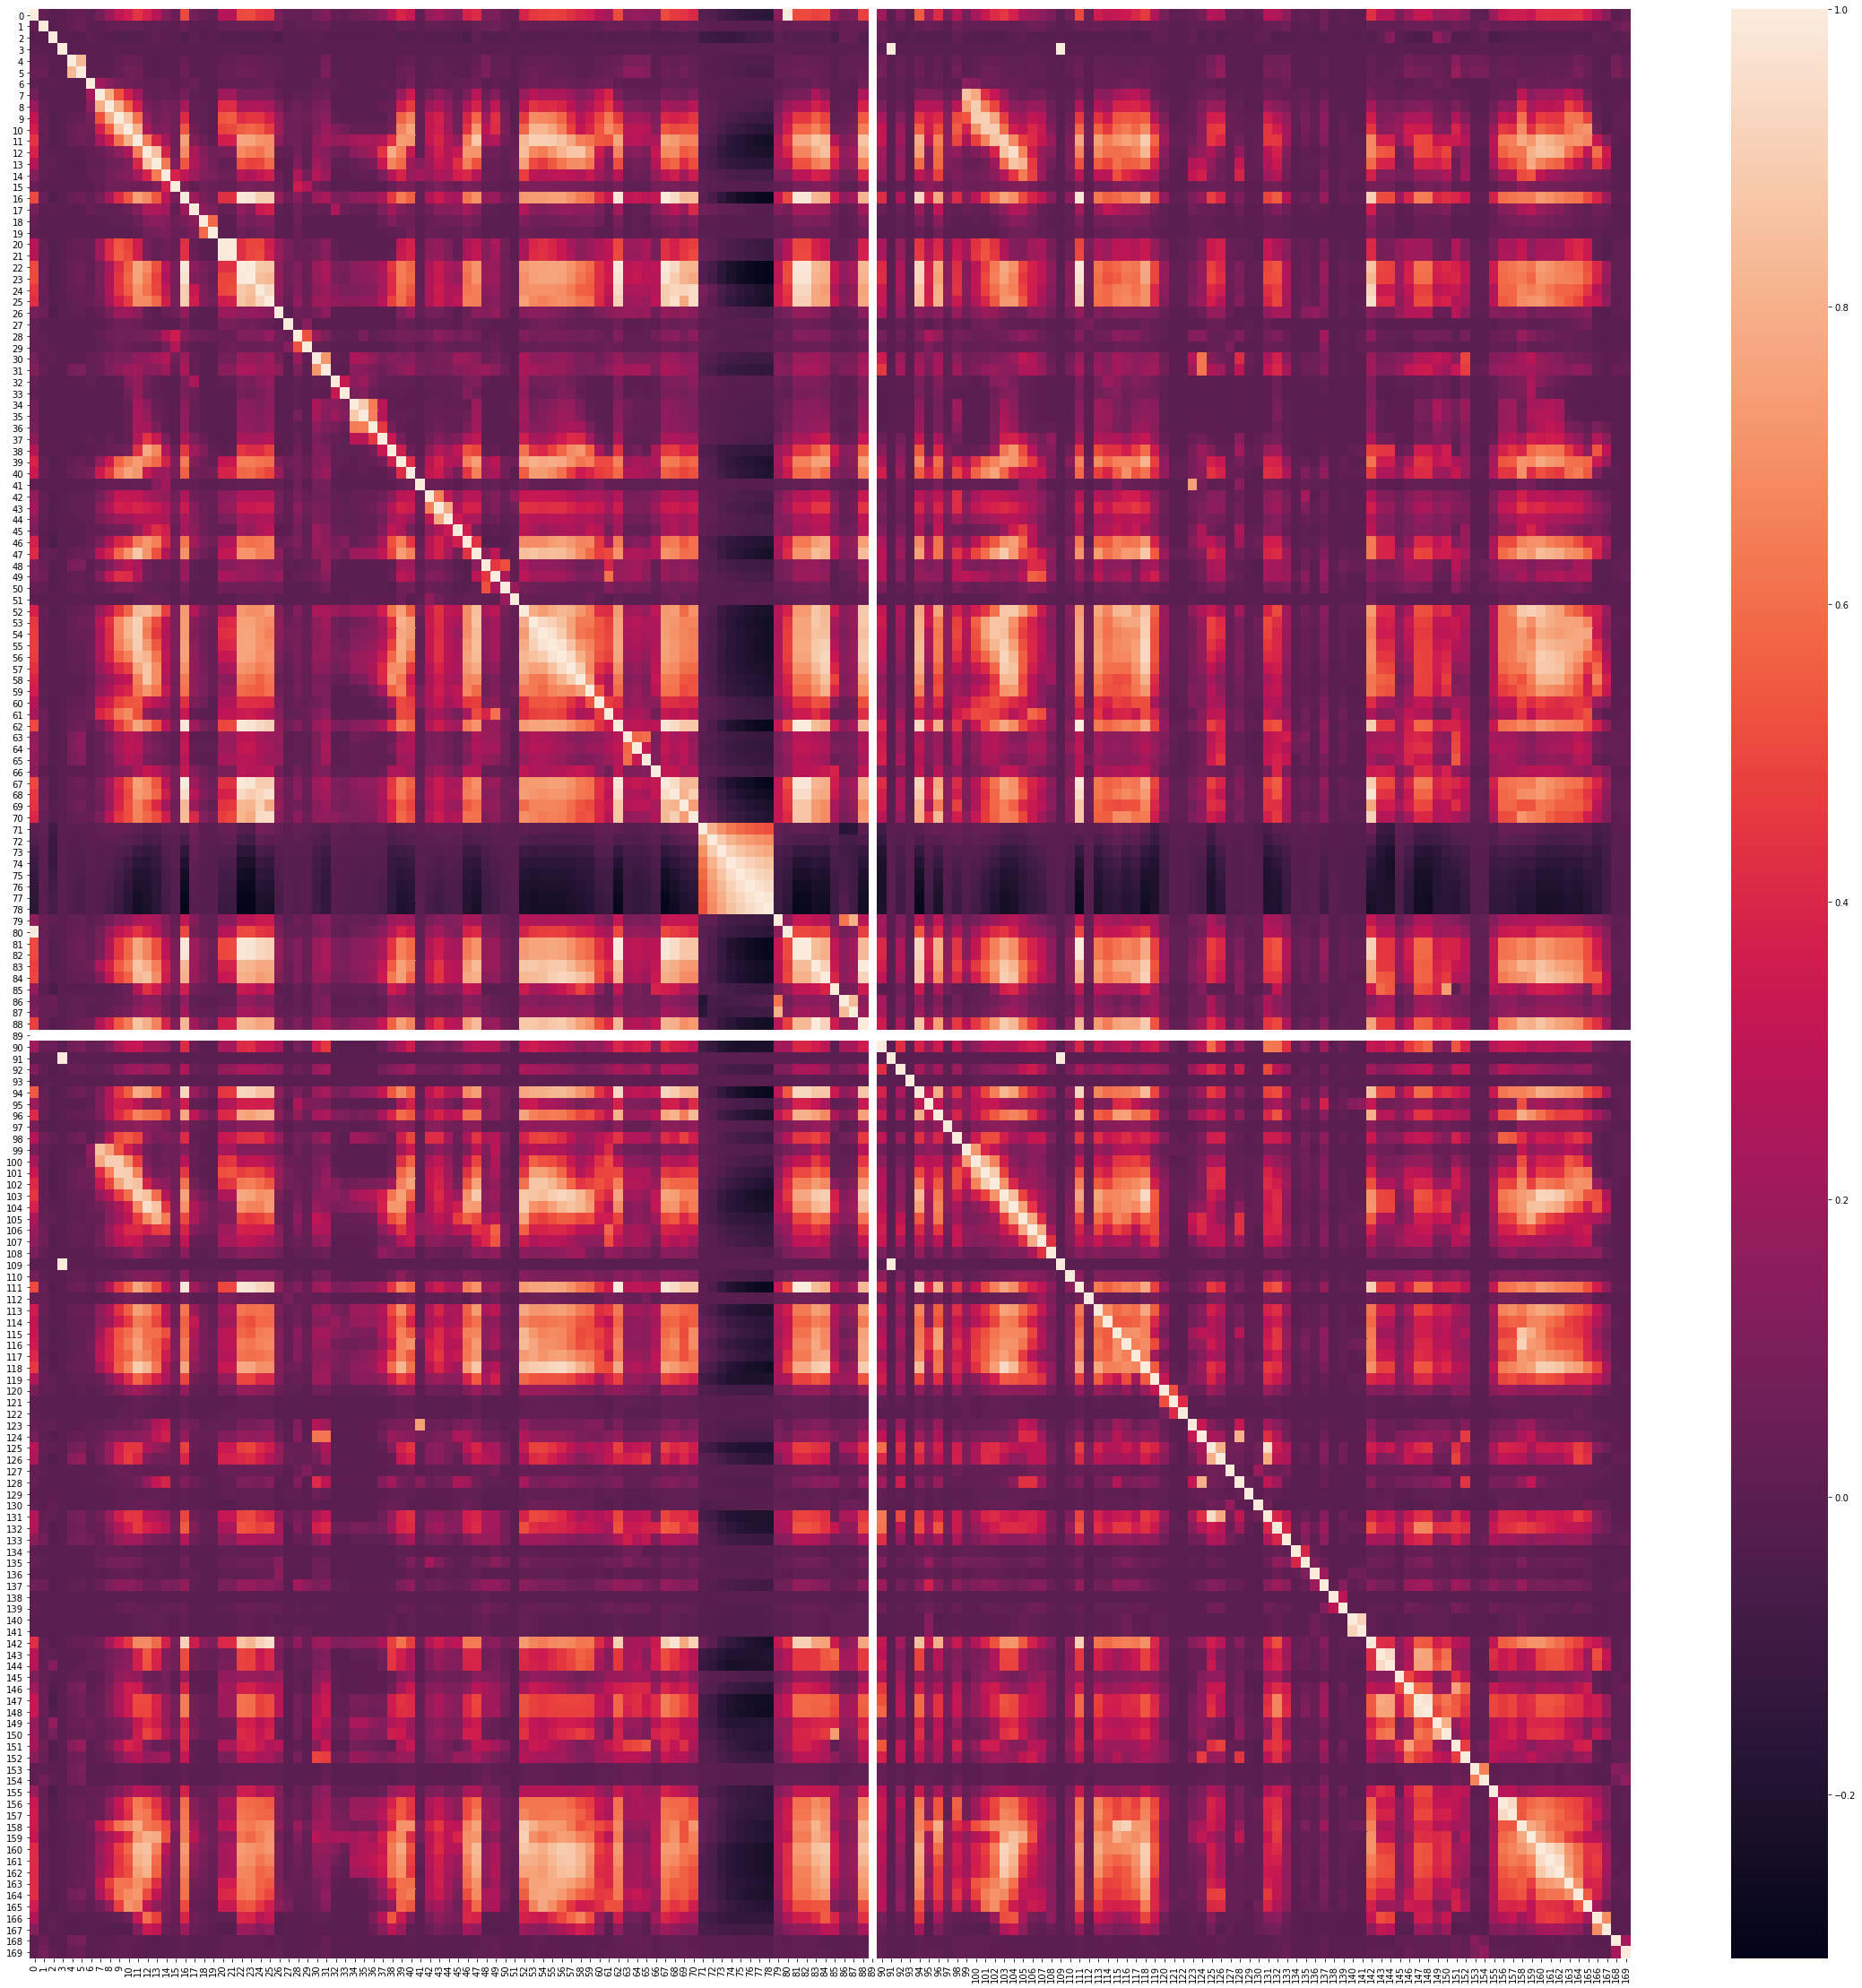

In [193]:
#train = pd.DataFrame(tra)
data_corr = dataX.corr()
plt.figure(figsize=(40,40))
sb.heatmap(data_corr)

## 1.(b).iv

Number of Features to Pick: 13.0

Top 13 features

               0
91   207.270274
109  206.876129
3    206.721500
122  192.522611
138  122.128153
27   113.882755
136  112.652450
134  111.369666
6     91.460654
29    86.085638
19    78.622988
51    77.999556
41    77.461101





<AxesSubplot:>

<Figure size 2160x2160 with 0 Axes>

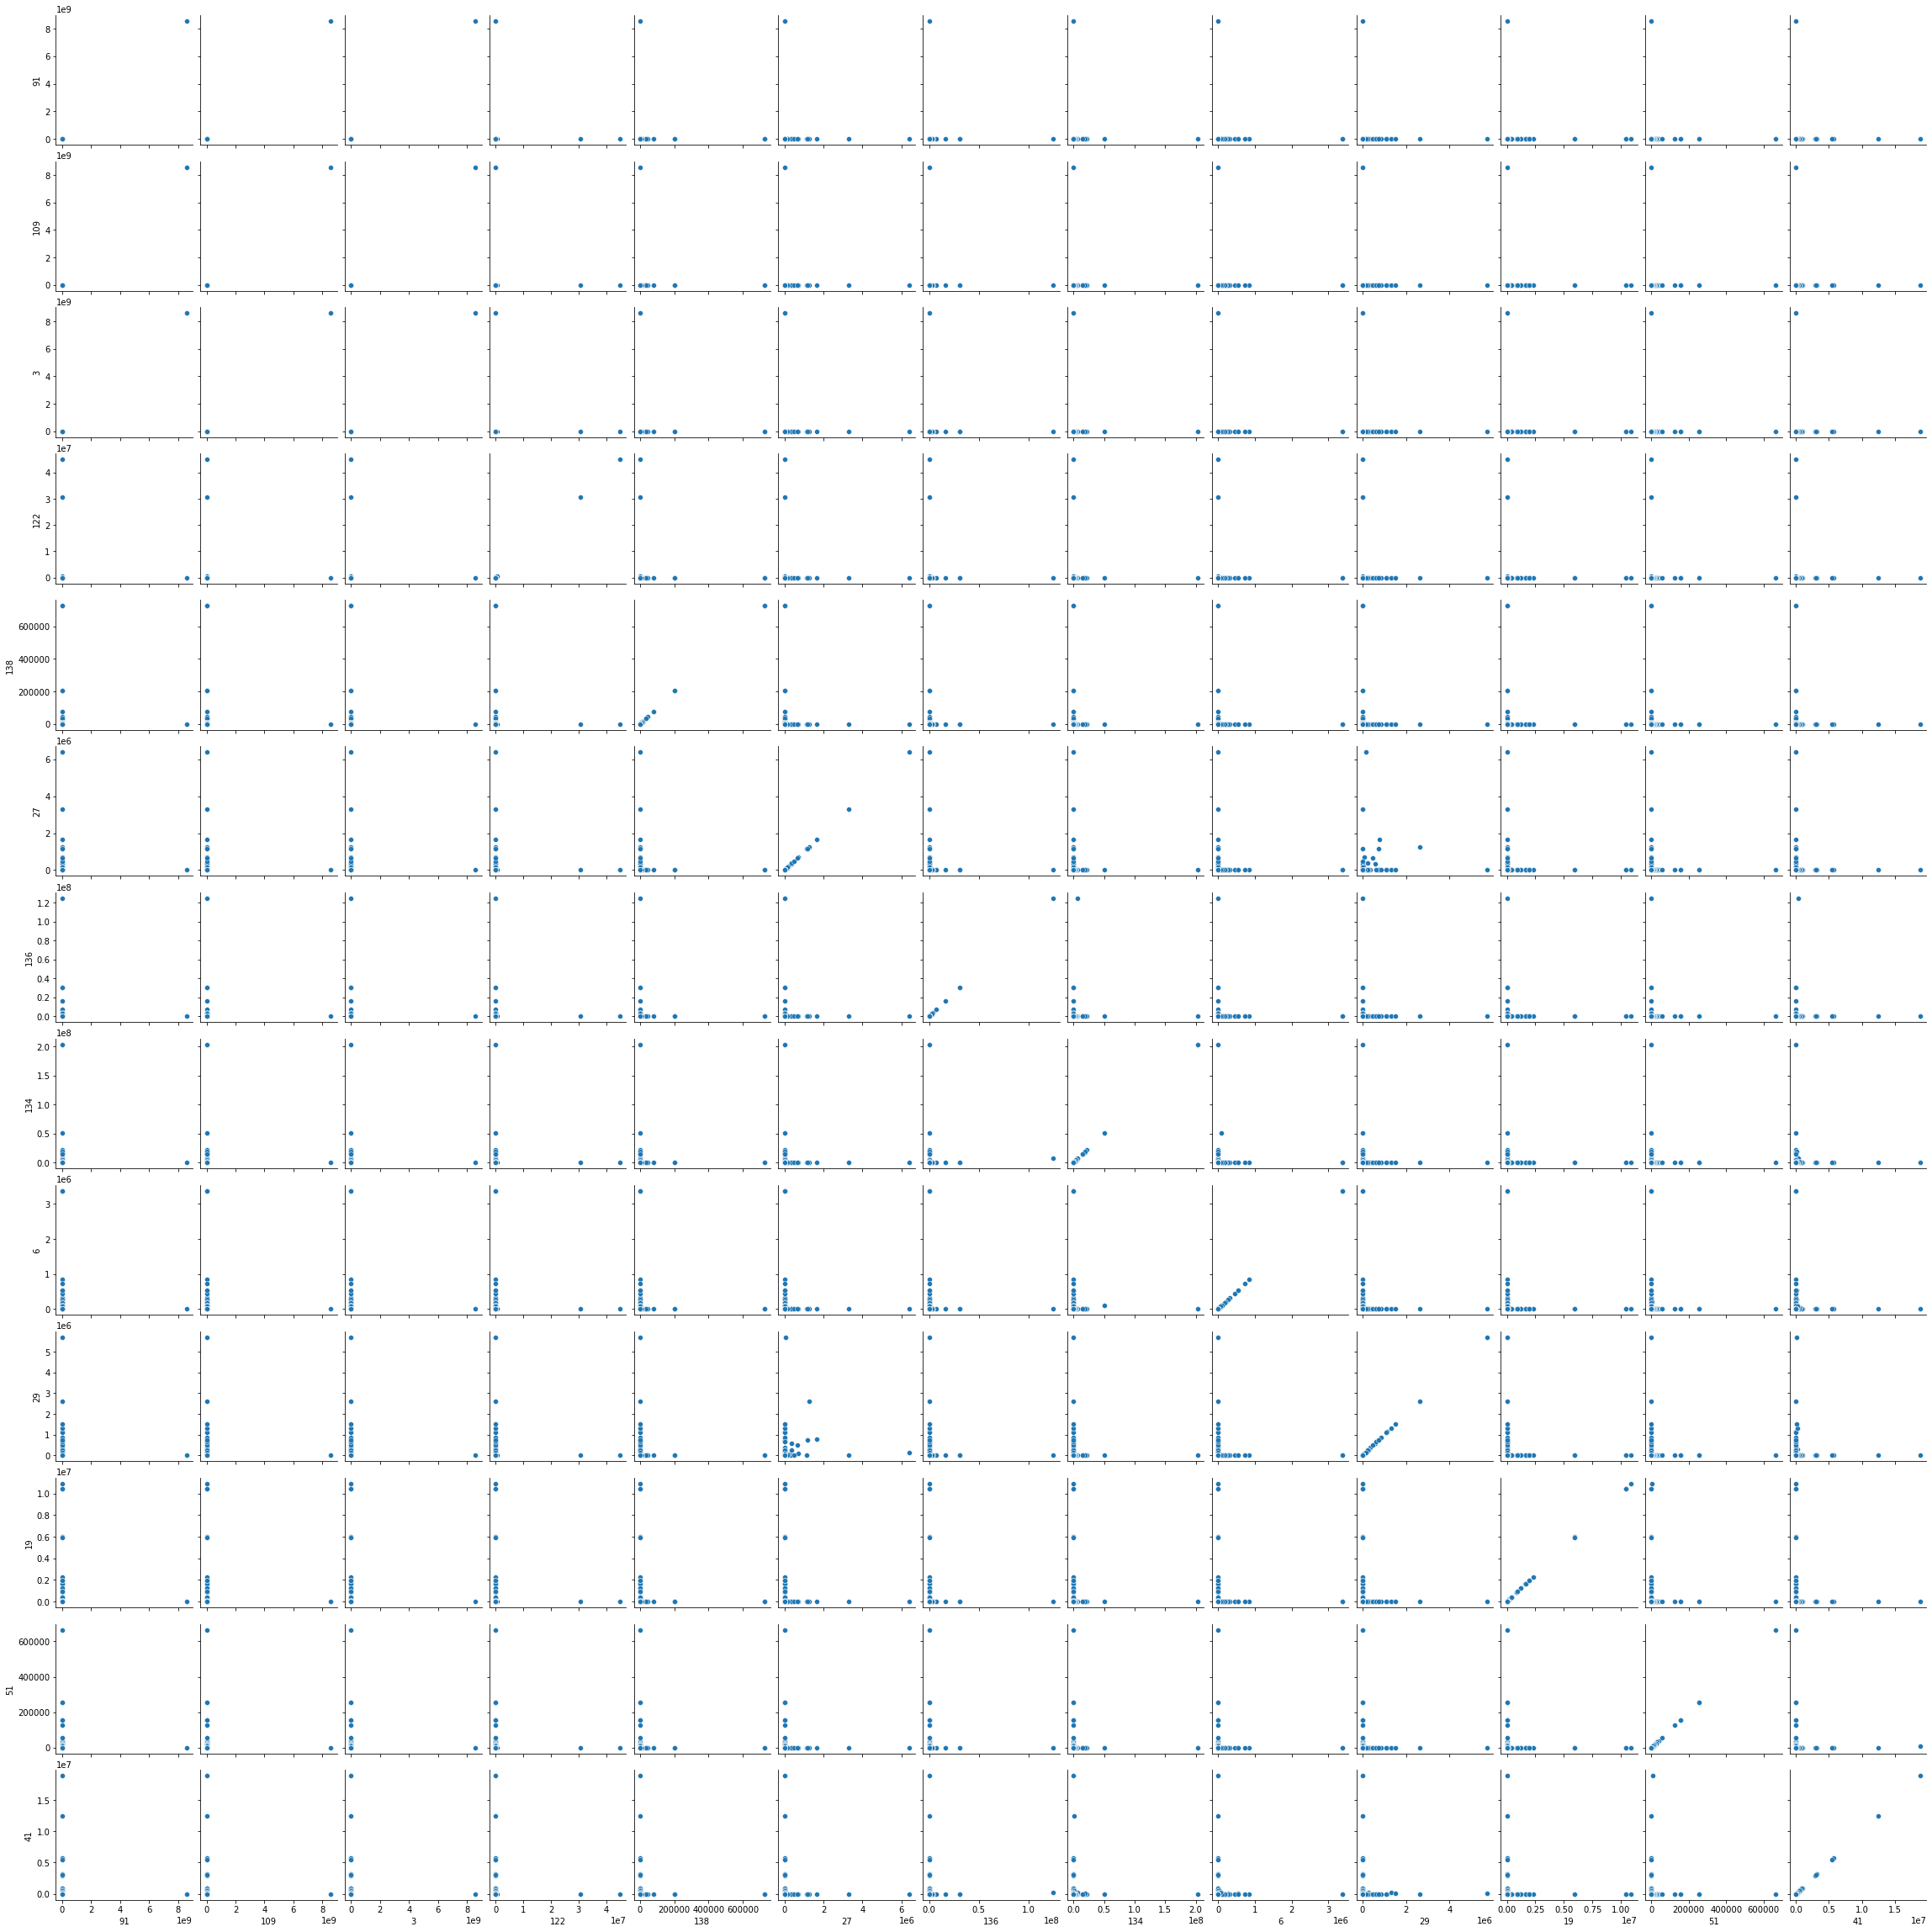

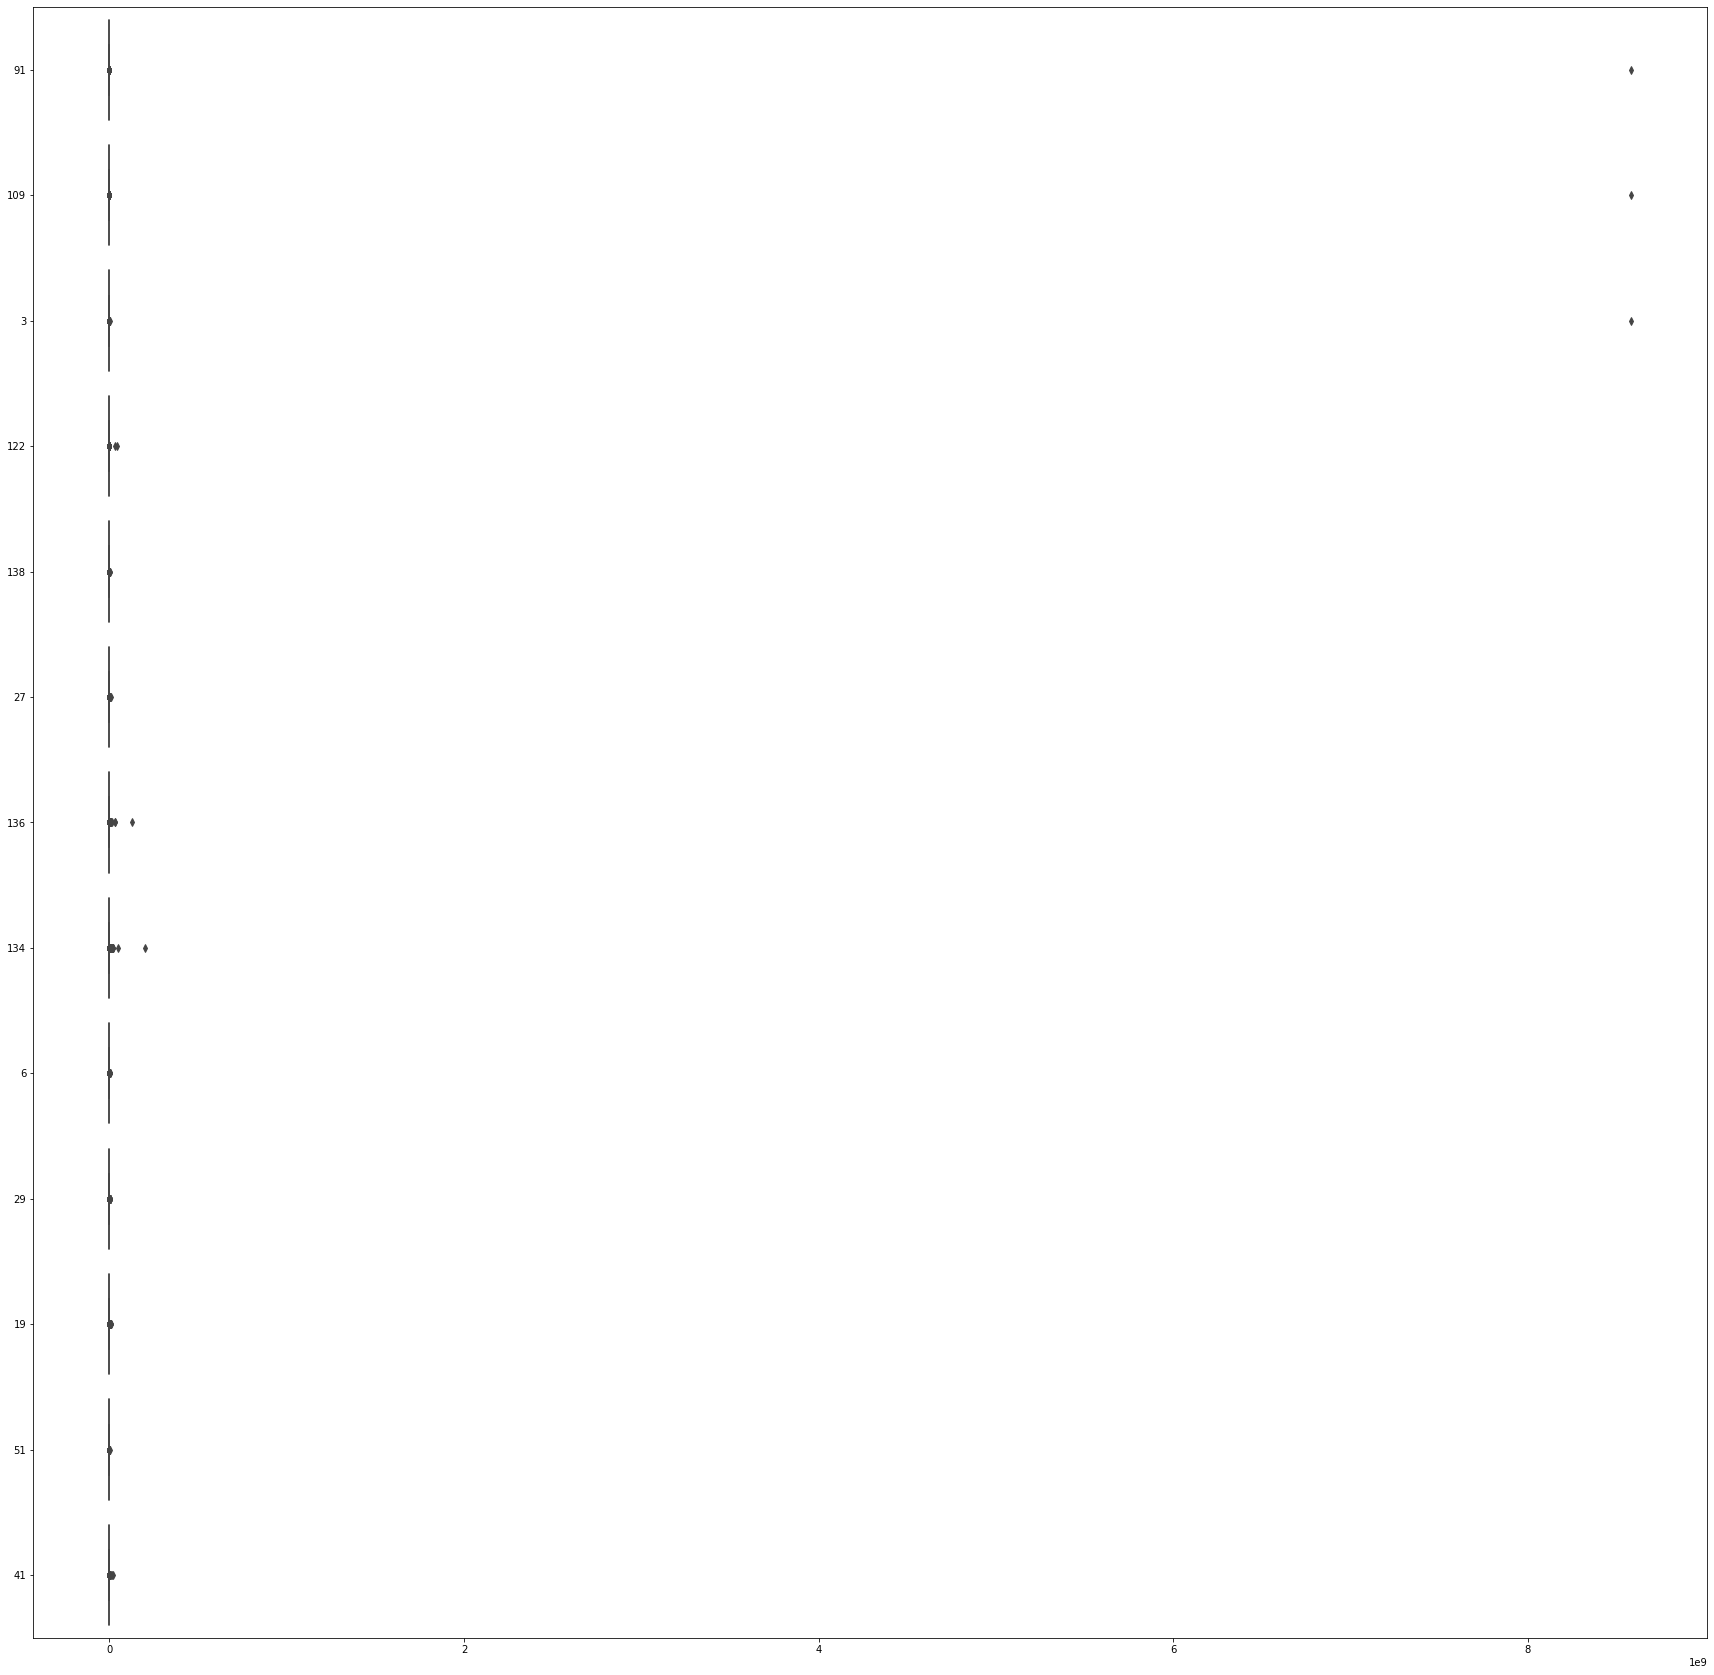

In [194]:
# find # of features to pick
featNum = np.round(np.sqrt(170))
print('Number of Features to Pick:', featNum)

# sort to get top features
sort_CV = CV.sort_values(by = 0, ascending = False)
sort_CV = pd.DataFrame(sort_CV)
high_CV = sort_CV.head(13).reset_index()
high_CV = pd.DataFrame(high_CV)

print('\nTop 13 features\n\n', sort_CV.head(13))
print('\n\n')

# get 11 columns from train data
ind =[91,109,3,122,138,27,136,134,6,29,19,51,41]
indVals = []
inds = dataX[ind]

# plot findings
plt.figure(figsize=(30,30))
sb.pairplot(data = inds, diag_kind=None)
plt.figure(figsize=(30,30))
#print(y_train)
sb.boxplot(data = inds, orient="h")




The scatterplot does not let me much about their significance, some values create linear relationships but most have similar scattered patterns and two few data points to make out greater relationships. The boxplots show there are few outliers which is a good indication, but not much more since of how dense the boxes are. 

## 1.(b).v

In [195]:
negCT = dataY['class'].value_counts()[0]
posCT = dataY['class'].value_counts()[1]

print('Positive Count:', posCT)
print()
print('Negative Count:', negCT)
print('This data set is imbalanced, there are tons more negative counts than positive counts')

Positive Count: 1375

Negative Count: 74625
This data set is imbalanced, there are tons more negative counts than positive counts


# 1.(c) --> Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassi cation for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [196]:
# creating a RF classifier
clf = RandomForestClassifier(oob_score=True) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(trainX, trainY.values.ravel())
 
# performing predictions on the test dataset
y_pred_train = clf.predict(trainX)
y_pred_test = clf.predict(testX)
 
# find metrics
trainCM = confusion_matrix(y_true=trainY, y_pred = y_pred_train)
trainRAS = roc_auc_score(y_true=trainY, y_score = y_pred_train)
trainRC = roc_curve(y_true=trainY, y_score = y_pred_train)
trainErr = 1- clf.score(trainX, trainY)


testCM = confusion_matrix(y_true=testY, y_pred = y_pred_test)
testRAS = roc_auc_score(y_true=testY, y_score = y_pred_test)
testRC = roc_curve(y_true=testY, y_score = y_pred_test)
testErr = 1 - clf.score(testX, testY)


oob = 1- clf.oob_score_

# print metrics

print("****Train Metric Values****\n")
print("Train Confusion Matrix:\n", trainCM)
print("\nTrain AUC_Score:", trainRAS)
print("\nTrain Misclassification:", trainErr)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (trainCM[0][0]/sum(trainCM[0]))
classPos = 1 - (trainCM[1][1]/sum(trainCM[1]))
print("\nTrain Misclassification Class Negative:", classNeg)
print("\nTrain Misclassification Class Positive:", classPos)



print("\n****Test Metric Values****\n")
print("Test Confusion Matrix:\n", testCM)
print("\nTest AUC_Score:", testRAS)
print("\nTest Misclassification:", testErr)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (testCM[0][0]/sum(testCM[0]))
classPos = 1 - (testCM[1][1]/sum(testCM[1]))
print("\nTest Misclassification Class Negative:", classNeg)
print("\nTest Misclassification Class Positive:", classPos)

print("\nOut of Bag Error:", oob)

****Train Metric Values****

Train Confusion Matrix:
 [[59000     0]
 [    0  1000]]

Train AUC_Score: 1.0

Train Misclassification: 0.0

Train Misclassification Class Negative: 0.0

Train Misclassification Class Positive: 0.0

****Test Metric Values****

Test Confusion Matrix:
 [[15609    16]
 [  108   267]]

Test AUC_Score: 0.8554879999999999

Test Misclassification: 0.007750000000000035

Test Misclassification Class Negative: 0.0010240000000000249

Test Misclassification Class Positive: 0.28800000000000003

Out of Bag Error: 0.006216666666666648


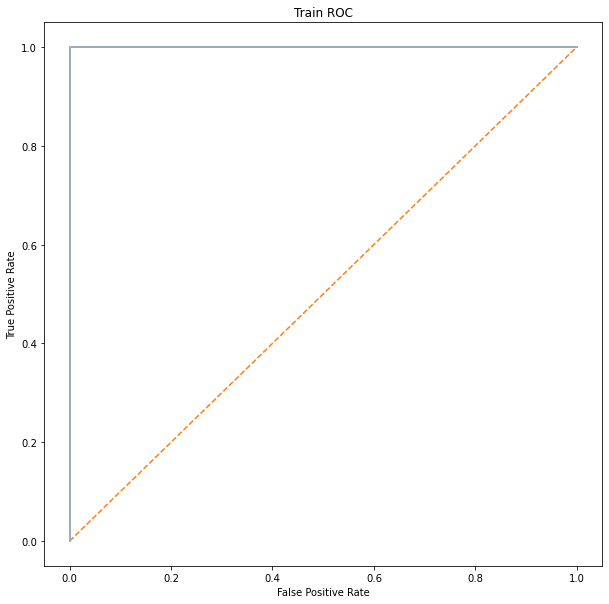

In [197]:
plt.subplots(1, figsize=(10,10))
plt.title('Train ROC')
plt.plot(trainRC[0], trainRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


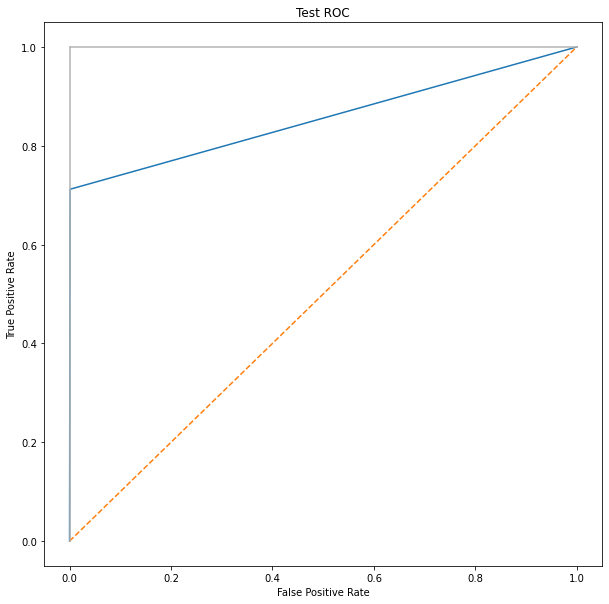

In [198]:
plt.subplots(1, figsize=(10,10))
plt.title('Test ROC')
plt.plot(testRC[0], testRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 1.(d) 

Class imbalanced is handled by changing the weights of each class and finding an impurity score. This will calculate how mixed the groups are and is measured with the gini or entropy.  Similarly one can also use bootstrap to change class weights but with in bootstrap samples. Lastly one can also randomly resample within a bootstrap sample so that class distribution changes. 

I will use the first method of changing class weights and finding an impurity score. 

In [199]:
# creating a RF classifier
clf = RandomForestClassifier(oob_score=True, class_weight='balanced') 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(trainX, trainY.values.ravel())
 
# performing predictions on the test dataset
y_pred_train = clf.predict(trainX)
y_pred_test = clf.predict(testX)
 
# find metrics
trainCM = confusion_matrix(y_true=trainY, y_pred = y_pred_train)
trainRAS = roc_auc_score(y_true=trainY, y_score = y_pred_train)
trainRC = roc_curve(y_true=trainY, y_score = y_pred_train)
trainErr = 1- clf.score(trainX, trainY)


testCM = confusion_matrix(y_true=testY, y_pred = y_pred_test)
testRAS = roc_auc_score(y_true=testY, y_score = y_pred_test)
testRC = roc_curve(y_true=testY, y_score = y_pred_test)
testErr = 1 - clf.score(testX, testY)


oob = 1- clf.oob_score_

# print metrics

print("****Train Metric Values****\n")
print("Train Confusion Matrix:\n", trainCM)
print("\nTrain AUC_Score:", trainRAS)
print("\nTrain Misclassification:", trainErr)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (trainCM[0][0]/sum(trainCM[0]))
classPos = 1 - (trainCM[1][1]/sum(trainCM[1]))
print("\nTrain Misclassification Class Negative:", classNeg)
print("\nTrain Misclassification Class Positive:", classPos)



print("\n****Test Metric Values****\n")
print("Test Confusion Matrix:\n", testCM)
print("\nTest AUC_Score:", testRAS)
print("\nTest Misclassification:", testErr)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (testCM[0][0]/sum(testCM[0]))
classPos = 1 - (testCM[1][1]/sum(testCM[1]))
print("\nTest Misclassification Class Negative:", classNeg)
print("\nTest Misclassification Class Positive:", classPos)



print("\nOut of Bag Error:", oob)

****Train Metric Values****

Train Confusion Matrix:
 [[59000     0]
 [    0  1000]]

Train AUC_Score: 1.0

Train Misclassification: 0.0

Train Misclassification Class Negative: 0.0

Train Misclassification Class Positive: 0.0

****Test Metric Values****

Test Confusion Matrix:
 [[15610    15]
 [  164   211]]

Test AUC_Score: 0.7808533333333333

Test Misclassification: 0.011187500000000017

Test Misclassification Class Negative: 0.0009599999999999609

Test Misclassification Class Positive: 0.43733333333333335

Out of Bag Error: 0.007900000000000018


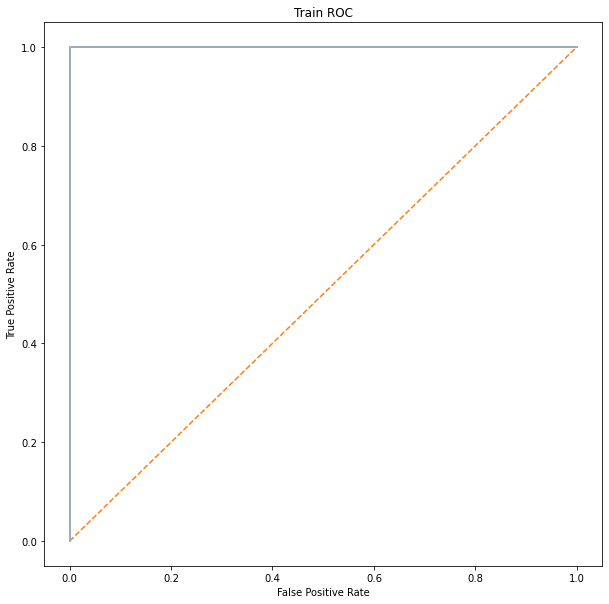

In [200]:
plt.subplots(1, figsize=(10,10))
plt.title('Train ROC')
plt.plot(trainRC[0], trainRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

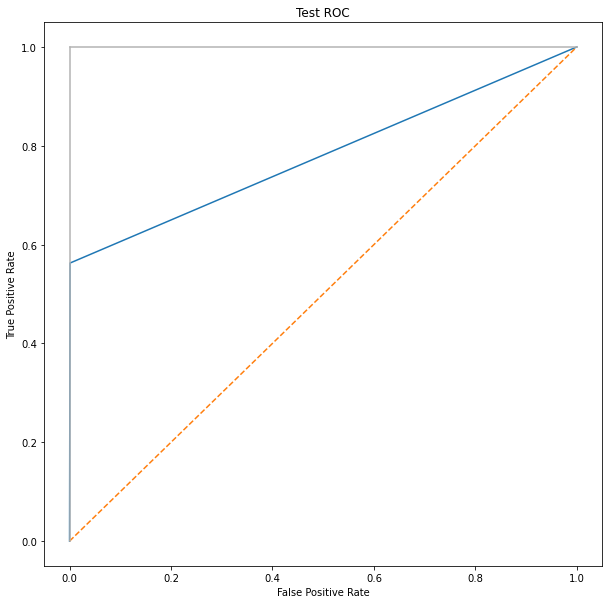

In [201]:
plt.subplots(1, figsize=(10,10))
plt.title('Test ROC')
plt.plot(testRC[0], testRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 1.(e) 

Best Regularization Term:
{'alpha': 1e-05}
Best CV Score:
0.9946166666666667
****Train Metric Values****

Train Confusion Matrix:
 [[59000     0]
 [    1   999]]

Train AUC_Score: 0.9995

Train Misclassification: 1.666666666666483e-05

Train Misclassification Class Negative: 0.0

Train Misclassification Class Positive: 0.0010000000000000009


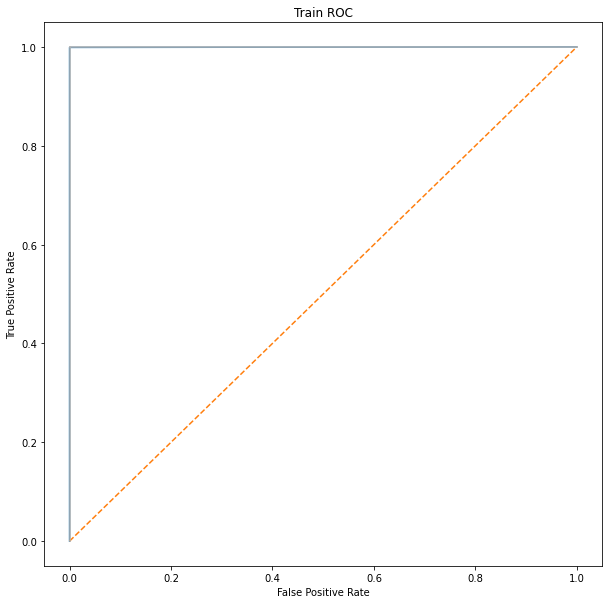

In [202]:
# create model
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', use_label_encoder =False)

# create list of alphas 10^-4 - 10^4
p = {"alpha": [.00001, .001, .01, .1, 1,  10, 100, 1000, 10000 ]}

# use cv=5
search = GridSearchCV(estimator= xg_reg, param_grid = p, cv = 5)
search.fit(trainX, trainY.values.ravel())

# print results
print("Best Regularization Term:")
print(search.best_params_)
print('Best CV Score:')
print(search.best_score_)

# performing predictions on the test dataset
y_pred_train = search.predict(trainX)
 
# find metrics
trainCM = confusion_matrix(y_true=trainY, y_pred = y_pred_train)
trainRAS = roc_auc_score(y_true=trainY, y_score = y_pred_train)
trainRC = roc_curve(y_true=trainY, y_score = y_pred_train)
trainErr = 1- search.score(trainX, trainY)

# print metrics

print("****Train Metric Values****\n")
print("Train Confusion Matrix:\n", trainCM)
print("\nTrain AUC_Score:", trainRAS)
print("\nTrain Misclassification:", trainErr)


# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (trainCM[0][0]/sum(trainCM[0]))
classPos = 1 - (trainCM[1][1]/sum(trainCM[1]))
print("\nTrain Misclassification Class Negative:", classNeg)
print("\nTrain Misclassification Class Positive:", classPos)



plt.subplots(1, figsize=(10,10))
plt.title('Train ROC')
plt.plot(trainRC[0], trainRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

****Test Metric Values****

Test Confusion Matrix:
 [[15607    18]
 [   78   297]]

Test AUC_Score: 0.895424

Test Misclassification: 0.006000000000000005

Test Misclassification Class Negative: 0.0011520000000000419

Test Misclassification Class Positive: 0.20799999999999996


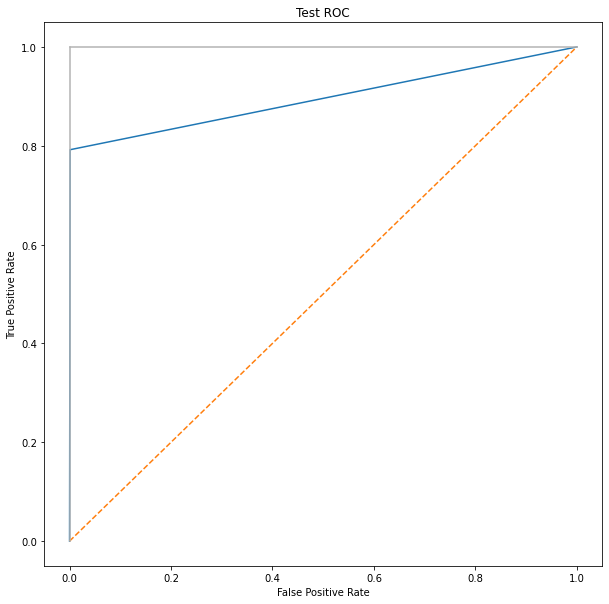

In [203]:
y_pred_train = search.predict(testX)
 
# find metrics
CM = confusion_matrix(y_true=testY, y_pred = y_pred_train)
RAS = roc_auc_score(y_true=testY, y_score = y_pred_train)
RC = roc_curve(y_true=testY, y_score = y_pred_train)
Err = 1 - search.score(testX, testY)

# print metrics

print("****Test Metric Values****\n")
print("Test Confusion Matrix:\n", CM)
print("\nTest AUC_Score:", RAS)
print("\nTest Misclassification:", Err)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (CM[0][0]/sum(CM[0]))
classPos = 1 - CM[1][1]/sum(CM[1])
print("\nTest Misclassification Class Negative:", classNeg)
print("\nTest Misclassification Class Positive:", classPos)



plt.subplots(1, figsize=(10,10))
plt.title('Test ROC')
plt.plot(RC[0], RC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Overall the training data performed better uing XGBoost and L1 penatalized logistic regression. The error was lower within the training set and the AUC score was higher, showing that the training model classified things better. The test results are still very good with a very low test error and pretty high AUC score. 

## 1.(f) 

Best Regularization Term:
{'classifier__alpha': 0.001}
Best CV Score:
0.9937666666666667
****Train Metric Values****

Train Confusion Matrix:
 [[59000     0]
 [    1   999]]

Train AUC_Score: 0.9995

Train Misclassification: 1.666666666666483e-05

Train Misclassification Class Negative: 0.0

Train Misclassification Class Positive: 0.0010000000000000009


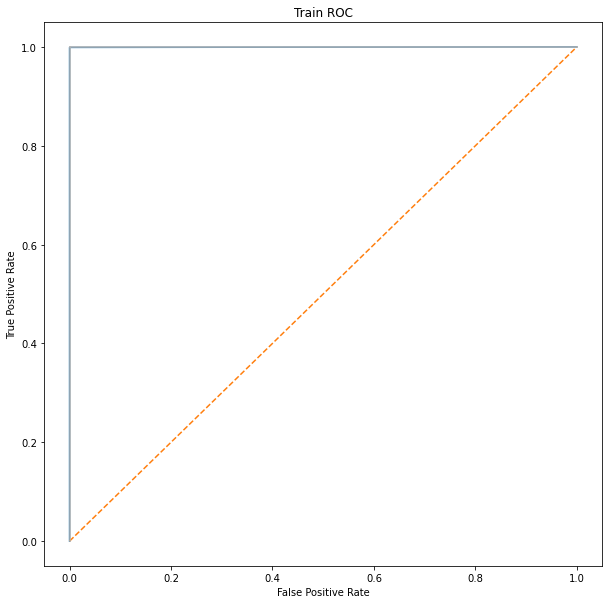

In [204]:
pipe = Pipeline(steps = [['smote', SMOTE()], ['classifier', xgb.XGBClassifier(objective ='reg:logistic', use_label_encoder =False)]])

p = {"classifier__alpha": [.00001, .001, .01, .1, 1,  10, 100, 1000, 10000 ]}


search = GridSearchCV(estimator=pipe,
                           param_grid=p,
                           cv=5,
                           n_jobs=-1)

search.fit(trainX, trainY)

# print results
print("Best Regularization Term:")
print(search.best_params_)
print('Best CV Score:')
print(search.best_score_)

# performing predictions on the test dataset
y_pred_train = search.predict(trainX)
 
# find metrics
trainCM = confusion_matrix(y_true=trainY, y_pred = y_pred_train)
trainRAS = roc_auc_score(y_true=trainY, y_score = y_pred_train)
trainRC = roc_curve(y_true=trainY, y_score = y_pred_train)
trainErr = 1- search.score(trainX, trainY)

# print metrics

print("****Train Metric Values****\n")
print("Train Confusion Matrix:\n", trainCM)
print("\nTrain AUC_Score:", trainRAS)
print("\nTrain Misclassification:", trainErr)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (trainCM[0][0]/sum(trainCM[0]))
classPos = 1 - (trainCM[1][1]/sum(trainCM[1]))
print("\nTrain Misclassification Class Negative:", classNeg)
print("\nTrain Misclassification Class Positive:", classPos)


plt.subplots(1, figsize=(10,10))
plt.title('Train ROC')
plt.plot(trainRC[0], trainRC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

****Test Metric Values****

Test Confusion Matrix:
 [[15374   251]
 [   51   324]]

Test AUC_Score: 0.923968

Test Misclassification: 0.018874999999999975

Test Misclassification Class Negative: 0.016063999999999967

Test Misclassification Class Positive: 0.136


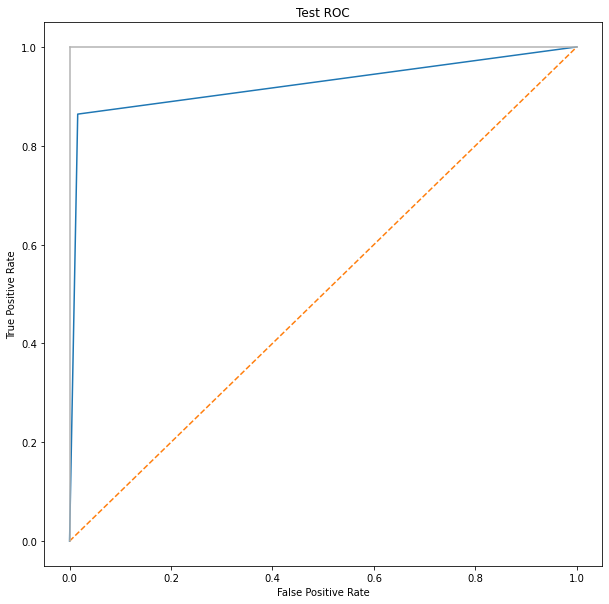

In [205]:
y_pred_train = search.predict(testX)
 
# find metrics
CM = confusion_matrix(y_true=testY, y_pred = y_pred_train)
RAS = roc_auc_score(y_true=testY, y_score = y_pred_train)
RC = roc_curve(y_true=testY, y_score = y_pred_train)
Err = 1 - search.score(testX, testY)

# print metrics

print("****Test Metric Values****\n")
print("Test Confusion Matrix:\n", CM)
print("\nTest AUC_Score:", RAS)
print("\nTest Misclassification:", Err)

# Misclassification for each class, take precision and use FP instead of TP to get misc rate vs correct rate
classNeg = 1 - (CM[0][0]/sum(CM[0]))
classPos = 1 - CM[1][1]/sum(CM[1])
print("\nTest Misclassification Class Negative:", classNeg)
print("\nTest Misclassification Class Positive:", classPos)




plt.subplots(1, figsize=(10,10))
plt.title('Test ROC')
plt.plot(RC[0], RC[1])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



The error is higher in the smote model vs the uncompensated model, but the test data within smote produced a better AUC score, meaning the model can classifiy each class better. Both models still produce low errors and high AUCs, in this case the smote model may be prefered becauses classes are distinguished better.   

## 2 --> ISLR 6.6.3


(a) Training RSS --> steadily decrease
(b) Test RSS --> increase and then decrease in a U shape
(c) Variance --> steadily increase
(d) (squared) bias --> steadily decrease 
(e) irreducible error --> remain constant


## 3 --> ISLR 6.6.5


 please refer to the pdf in my submission as I was not able to upload it to my notebook!

## 4 --> ISLR 8.4.5


0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75

Majority Vote, we will pick the class based on the majority of votes and use 0.5 to classify, if greater than 0.5 then class red and less than 0.5 class green

0.1 < 0.5
0.15 < 0.5
0.2 < 0.5
0.2 < 0.5
0.55 > 0.5
0.6 > 0.5
0.6 > 0.5
0.65 > 0.5
0.7 > 0.5
0.75 > 0.5

4 less than 0.5
6 greater than 0.5

The class would be Red

Average Probabilty, we will take the mean of the 10 samples and if it is greater than 0.5 it will be class red and if it is less than 0.5 it will be class green

sum(0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75)/10 = 4.5/10 = 0.45

Since 0.45 < 0.5 then the class will be Green

## 5 --> ISLR 9.7.3

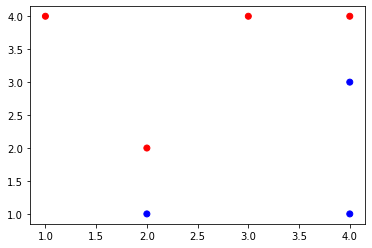

In [206]:
## (a)

x = [[3, 4, 'Red'],
[2,2,'Red'],
[4,4,'Red'],
[1,4,'Red'],
[2, 1, 'Blue'],
[4, 3, 'Blue' ],
[4 ,1, 'Blue']]
col = ['X1', 'X2', 'Y']

data=pd.DataFrame(x, columns = col)

x = data.iloc[:,0:1]
y = data['Y']

plt.scatter(data['X1'], data['X2'], c =y)

(0.0, 5.0)

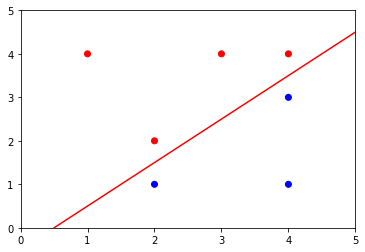

In [207]:
## (b)


# (2,1), (2,2) --> (4,3)/2 --> (2,1.5)
# (4,3), (4,4) --> (8,7)/2 --> (4,3.5)
# m = 3.5-1.5/4-2 = 2/2 = 1
# y = x+b --> 1.5 = 2 + b --> -0.5
# b = -0.5
# x1 = x2 - 0.5 --> X1 - X2 + 0.5 = 0
# Equation -0.5 + X1 - X2 = 0


x = np.linspace(0.5, 5)
y1 = np.linspace(0, 4.5 )

plt.scatter(data['X1'], data['X2'], c = y)
plt.plot(x, y1, 'k-', color = 'r')
plt.xlim(0,5)
plt.ylim(0,5)

In [208]:
## (c)

# Class Red --> -0.5 + X1 - X2 > 0 
# Class Blue --> -0.5 + X1 - X2 < 0

# B0, B1, B2 --> (-0.5, 1, -1)


(0.0, 5.0)

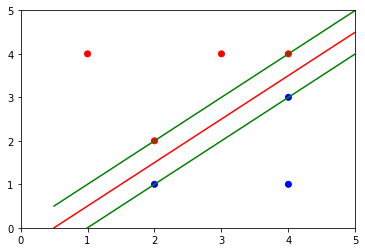

In [209]:
## (d)

plt.scatter(data['X1'], data['X2'], c = y)
plt.plot(x, y1, 'k-', color = 'r')
plt.plot(x, y1 + 0.5, 'k-', color = 'g')
plt.plot(x, y1 - 0.5, 'k-', color = 'g')
plt.xlim(0,5)
plt.ylim(0,5)

In [210]:
## (e)

# Support Vectors are 
# Red --> (2,2) & (4,4)
# Blue --> (2,1) & (4,3)

In [211]:
## (f)

# Since the 7th point is not included within the support vector margin a slight 
# change in it's position would not affect the equation. The 7th point would 
# need to move into the support vector margins to cause an effect on the hyperplane.

(0.0, 5.0)

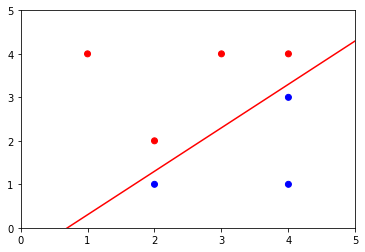

In [212]:
## (g)


# Here I will just change B0 from -0.5 to -0.2 
# Equation -0.2 + X1+ - (X2) = 0


x = np.linspace(0.5, 5)
y1 = np.linspace(0, 4.5)

plt.scatter(data['X1'], data['X2'], c = y)
plt.plot(x, y1-.2, 'k-', color = 'r')
plt.xlim(0,5)
plt.ylim(0,5)

(0.0, 5.0)

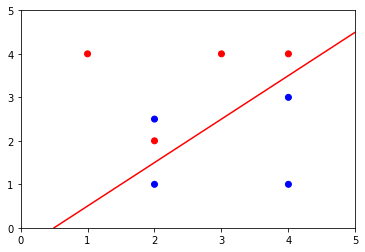

In [213]:
## (h)

# If I add a point at (2,2.5) within class Blue then the classes are no longer seperable
# below you can see that this point makes it impossible for a line to seperate red and blue points

x = [[3, 4, 'Red'],
[2,2,'Red'],
[4,4,'Red'],
[1,4,'Red'],
[2, 1, 'Blue'],
[4, 3, 'Blue' ],
[4 ,1, 'Blue'],
[2, 2.5 ,'Blue']]

col = ['X1', 'X2', 'Y']

data=pd.DataFrame(x, columns = col)

x = data.iloc[:,0:1]
y = data['Y']

x = np.linspace(0.5, 5)
y1 = np.linspace(0, 4.5)

plt.scatter(data['X1'], data['X2'], c = y)
plt.plot(x, y1, 'k-', color = 'r')
plt.xlim(0,5)
plt.ylim(0,5)
